# AppStat 2023 Project

## Group Members
- Andras
- Ellen
- Oscar
- Pernille
- Rasmine 

In [301]:
Plot_everything = True

## Error propagation
Error propagation the local acceleration due to gravity _g_ using a pendulum and a slope experiment.

In [302]:
from IPython.core.display import Latex

def lprint(*args,**kwargs):
    """Pretty print arguments as LaTeX using IPython display system 
    
    Parameters
    ----------
    args : tuple 
        What to print (in LaTeX math mode)
    kwargs : dict 
        optional keywords to pass to `display` 
    """
    display(Latex('$$'+' '.join(args)+'$$'),**kwargs)

In [303]:
# Import SymPy: 
from sympy import * 
    
# Define variables:
L,T,theta,R,d, gp, gs,a = symbols("L, T, theta, R, d, g_pendulum, g_slope,a")
dL,dT,dth,dR,dd,dgp,dgs,da = symbols("sigma_L, sigma_T, sigma_theta, sigma_r, sigma_d, sigma_gP,sigma_gS,sigma_a")

# Pendulum:
# Define relation, and print:
gp = L * (2 * pi / T)**2 
lprint(latex(Eq(symbols('g_pendulum'),gp)))

# Calculate uncertainty and print:
dgp = sqrt((gp.diff(L) * dL)**2 + (gp.diff(T) * dT)**2)
lprint(latex(Eq(symbols('sigma_gP'), dgp)))

# Turn expression into numerical functions 
fP = lambdify((L,T),gp)
fdP = lambdify((L,dL,T,dT),dgp)

# Define values and their errors
# vL, vdL = mu1,sig1
# vT, vdT = mu2,sig2

vL, vdL = 1.5,0.2
vT, vdT = 3,0.5


# Numerically evaluate expressions and print 
vP = fP(vL,vT)
vdP = fdP(vL,vdL,vT,vdT)
lprint(fr'g = ({vP:.3f} \pm {vdP:.3f})\,\mathrm{{m/s^2}}')

# Pendulum:
# Define relation, and print:
gs = a/sin(theta) * (1+2/5 * R**2 / (R**2-(d/2)**2)) 
lprint(latex(Eq(symbols('g_slope'),gs)))

# Calculate uncertainty and print:
dgs = sqrt((gs.diff(a) * da)**2 + (gs.diff(theta) * dth)**2+ (gs.diff(R) * dR)**2+ (gs.diff(d) * dd)**2)
lprint(latex(Eq(symbols('sigma_gS'), dgs)))

# Turn expression into numerical functions 
fP = lambdify((a,theta,R,d),gs)
fdP = lambdify((a,da,theta,dth,R,dR,d,dd),dgs)

# Define values and their errors
# vL, vdL = mu1,sig1
# vT, vdT = mu2,sig2
va,vtheta,vR,vd = 6.2, 30, 5, 5.0

vda,vdtheta,vdR,vdd = 0.2, 2, 0.2, 0.1

# Numerically evaluate expressions and print 
vP = fP(va,vtheta,vR,vd)
vdP = fdP(va,vda,vtheta,vdtheta,vR,vdR,vd,vdd)
lprint(fr'g = ({vP:.3f} \pm {vdP:.3f})\,\mathrm{{m/s^2}}')



# NOTE: Do the above analytical calculation before you continue below! Possibly use SymPy for the differentiations.

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

### Pendulum
- Pendulum length: Measured both with measuring tape and laser.
- Pendulum period: Measured over several (e.g. 25+) swings.
- Pendulum timing precisions: Accuracy of timing of each team member 

In [304]:
import numpy as np     
import pandas as pd                                    # Data analysis package
import matplotlib.pyplot as plt                        # Plots and figures like you know them from Matlab   
from scipy import stats                             # Make the plots nicer to look at
from iminuit import Minuit                             # The actual fitting tool, better than scipy's
import sys                                             # Modules to see files and folders in directories


sys.path.append('External_Functions')
from ExternalFunctions import Chi2Regression, BinnedLH, UnbinnedLH
from ExternalFunctions import nice_string_output, add_text_to_ax 



r = np.random                         # Random generator
r.seed(42)  


In [305]:

# Load measured data for each student

pend_1  = np.loadtxt('Data/oscar_2.dat', delimiter='\t')
pend_2  = np.loadtxt('Data/pernille_2.dat', delimiter='\t')
pend_3  = np.loadtxt('Data/andras_1.dat', delimiter='\t')
pend_4  = np.loadtxt('Data/ellen1.dat', delimiter='\t')
pend_5  = np.loadtxt('Data/ras_1.dat', delimiter='\t')

Names = ['Oscar','Pernille','Andras','Ellen','Ras']

periods = np.array([pend_1[:,1],pend_2[:,1],pend_3[:,1],pend_4[:,1],pend_5[:,1]])

print(periods)

[array([ 2.7179,  5.3848,  8.0746, 10.7785, 13.4979, 16.1857, 18.9243,
        21.5405, 24.2752, 27.0131, 29.71  , 32.3868, 35.1323, 37.7614,
        40.5224, 43.2034, 45.9511, 48.6534, 51.3479, 54.0304, 56.6648,
        59.4365, 62.1428, 64.8305, 67.5583, 70.2099, 72.8943, 75.6651,
        78.3209, 81.0857])
 array([ 2.6923,  5.3731,  8.0441, 10.8051, 13.4678, 16.1716, 18.8195,
        21.5513, 24.2722, 26.9629, 29.6587, 32.3625, 35.0998, 37.7385,
        40.4253, 43.198 , 45.8699, 48.533 , 51.2882, 54.0102, 56.6577,
        59.3722, 62.104 , 64.7845, 67.4682, 70.1938, 72.8952, 75.62  ,
        78.3185])
 array([  2.9852,   5.662 ,   8.4261,  11.0741,  13.7369,  16.4956,
         19.1756,  21.9083,  24.5972,  27.2253,  29.9782,  32.7271,
         35.3075,  38.1067,  40.7951,  43.4699,  46.176 ,  48.8602,
         51.5967,  54.2366,  56.9882,  59.6285,  62.3613,  65.0779,
         67.7383,  70.4888,  73.2125,  75.8758,  78.6004,  81.2875,
         83.9913,  86.6587,  89.3312,  92.067 ,

/var/folders/s1/rmb66kbs1l17hcxhqrplz5tc0000gn/T/ipykernel_99058/1433470066.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  periods = np.array([pend_1[:,1],pend_2[:,1],pend_3[:,1],pend_4[:,1],pend_5[:,1]])


In [306]:


# Define the linear model
def linear_model(x, a, b):
    return a * x + b

# Gaussian function for fitting
def gaussian(x, amplitude, mean, stddev):
    return amplitude * np.exp(-((x - mean)**2) / (2 * stddev**2))

# Calculate the residuals
def calculate_rms_residuals(x_data, y_data, fit_params):
    residuals = y_data - linear_model(x_data, *fit_params)
    return np.sqrt(residuals**2)


In [307]:


N_measurements = 25
N_exp = 5
x_data = np.arange(N_measurements)+1
N_bins = 30


Pendulum_Slope = np.zeros(N_exp)
Pendulum_stddev = np.zeros(N_exp)
Pendulum_error = np.zeros(N_exp)


residuals =list()
residuals_rmse =list()

In [308]:
# # Plot the data together with the fit
# avg_residuals = list()
# fig, ax = plt.subplots(nrows=2, figsize=(10, 6))
# average_period = np.zeros(N_measurements)
# for i in range(N_exp):
#     period = periods[i]
#     period = period[:25]-period[0]
#     average_period += period/N_exp
#     ax[0].plot(x_data, period, 'o', label=Names[i])
# print(average_period)
# chi2_object = Chi2Regression(linear_model, x_data, average_period)
# m = Minuit(chi2_object,a=2.5,b=0)
# m.migrad()

# Chi2Lin = m.fval # the chi2 value
# NvarLin = 2                      # Number of variables (alpha0 and alpha1)
# NdofLin = N_measurements - NvarLin   # Number of degrees of freedom
# ProbLin =  stats.chi2.sf(Chi2Lin, NdofLin) # The chi2 probability given N_DOF degrees of freedom

# ax[0].plot(x_data, linear_model(x_data, m.values['a'], m.values['b']), '--', label='Fit')
# ax[0].set_xlabel('Measurement number')
# ax[0].set_ylabel('Period [s]')
# ax[0].set_title('Pendulum period')
# d = {'Intercept':[m.values['b'], m.errors['b']],
#         'Slope':    [m.values['a'], m.errors['a']],
#         'Chi2':     Chi2Lin,
#         'ndf':      NdofLin,
#         'Prob':     ProbLin,
#         }

# ax[0].text(0.05, 0.95, nice_string_output(d, extra_spacing=2, decimals=3), family='monospace', transform=ax[0].transAxes, fontsize=10, verticalalignment='top')

# for i in range(N_exp):
#     period = periods[i]
#     period = period[:25]-period[0]
#     residual = period - linear_model(x_data, m.values['a'], m.values['b'])
#     avg_residuals.append(residual)

# mean, stddev = stats.norm.fit(np.hstack(avg_residuals))
# print(mean, stddev)
# ax[1].hist(np.hstack(avg_residuals), bins=10, density=True, label='Residuals')

/Users/oscarobel/Github/AppStat2023-Project/External_Functions/ExternalFunctions.py:113: VisibleDeprecationWarning: make_func_code is deprecated: Use of ``func_code`` attribute to declare parameters is deprecated. Use ``_parameters`` instead, which is a dict of parameter names to limits.
  self.func_code = make_func_code(describe(self.f)[1:])


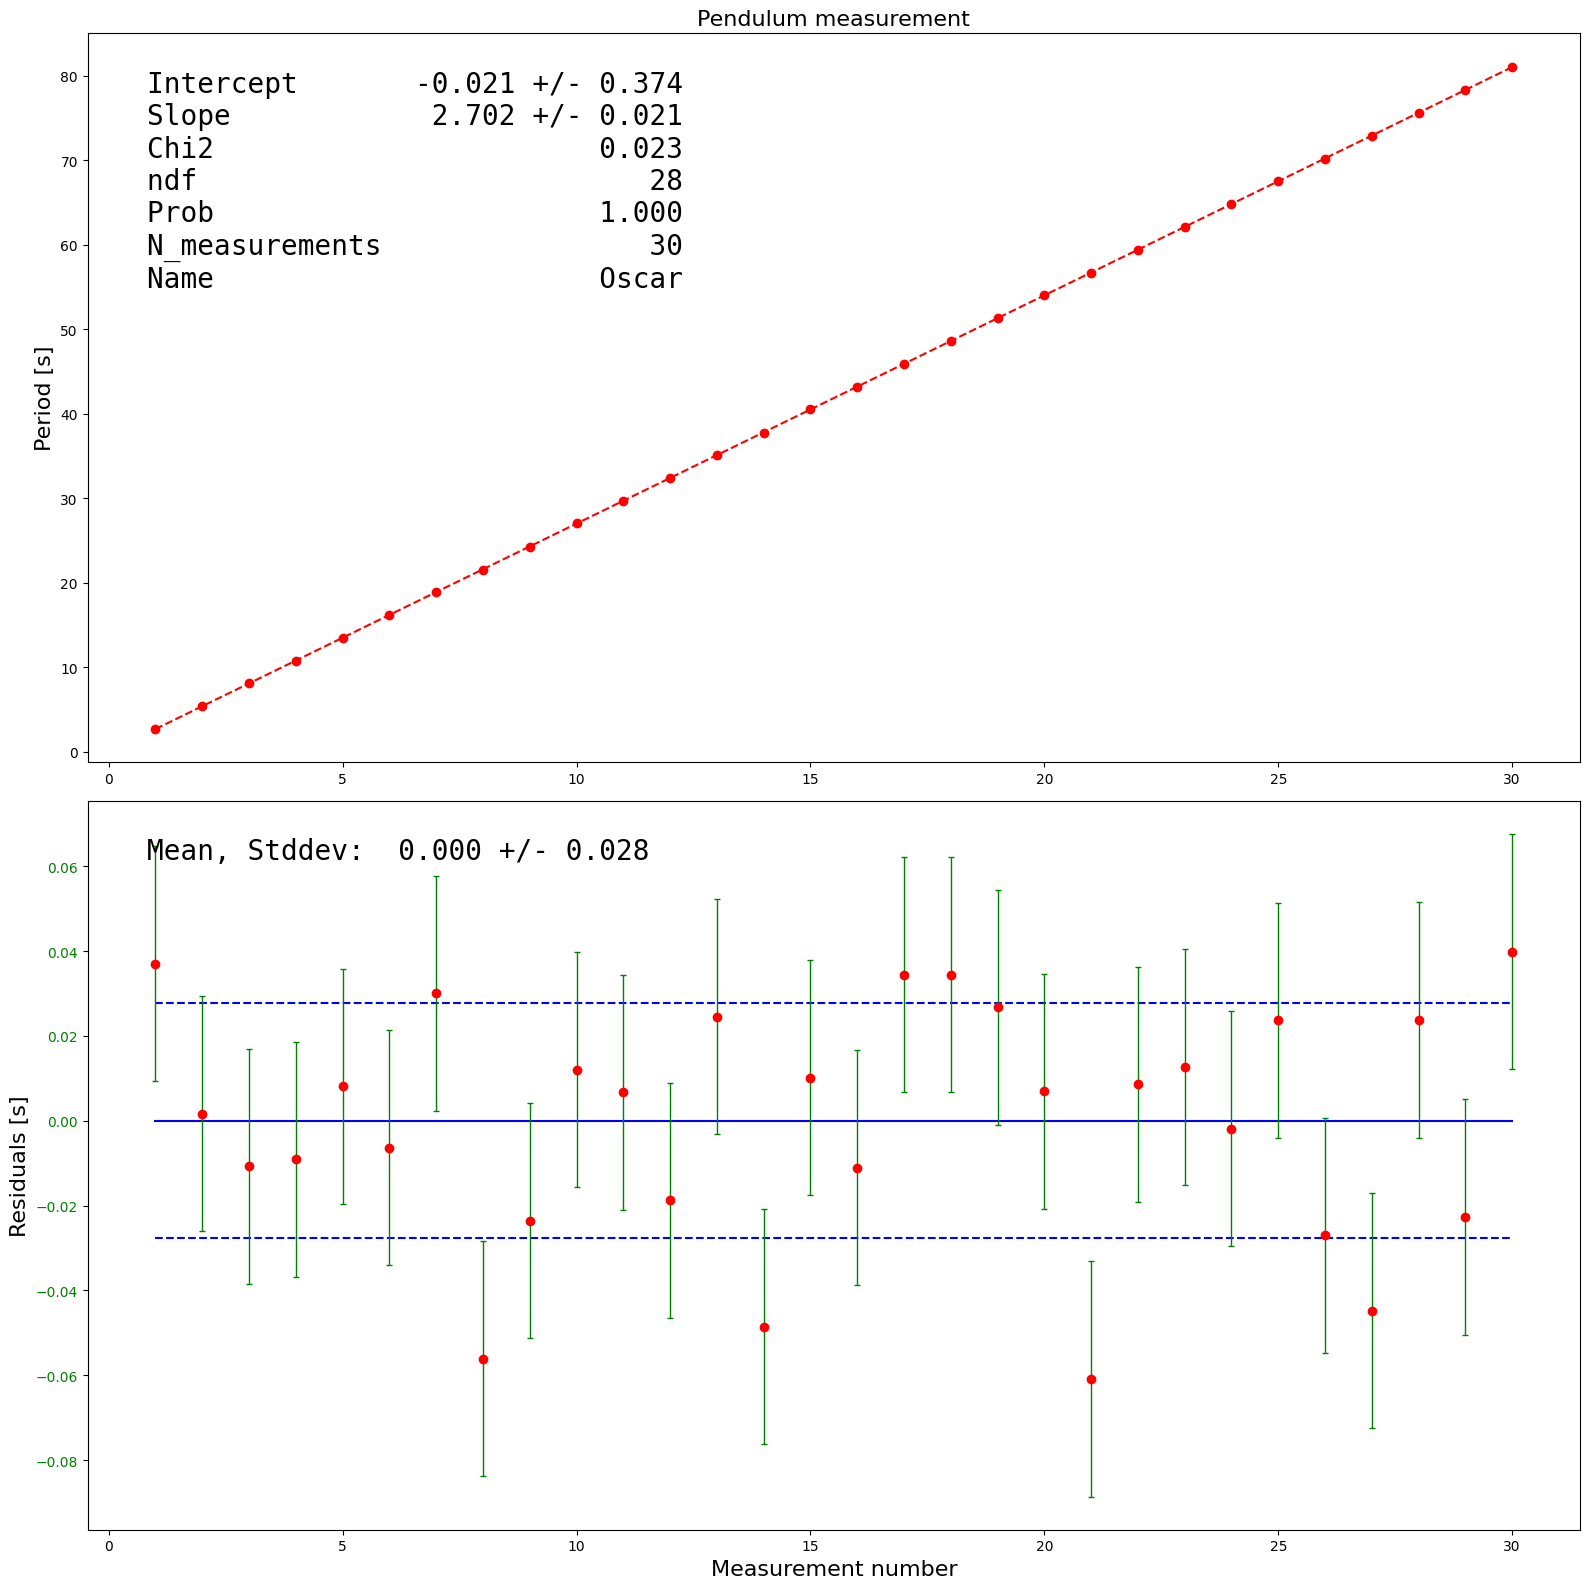

/Users/oscarobel/Github/AppStat2023-Project/External_Functions/ExternalFunctions.py:113: VisibleDeprecationWarning: make_func_code is deprecated: Use of ``func_code`` attribute to declare parameters is deprecated. Use ``_parameters`` instead, which is a dict of parameter names to limits.
  self.func_code = make_func_code(describe(self.f)[1:])


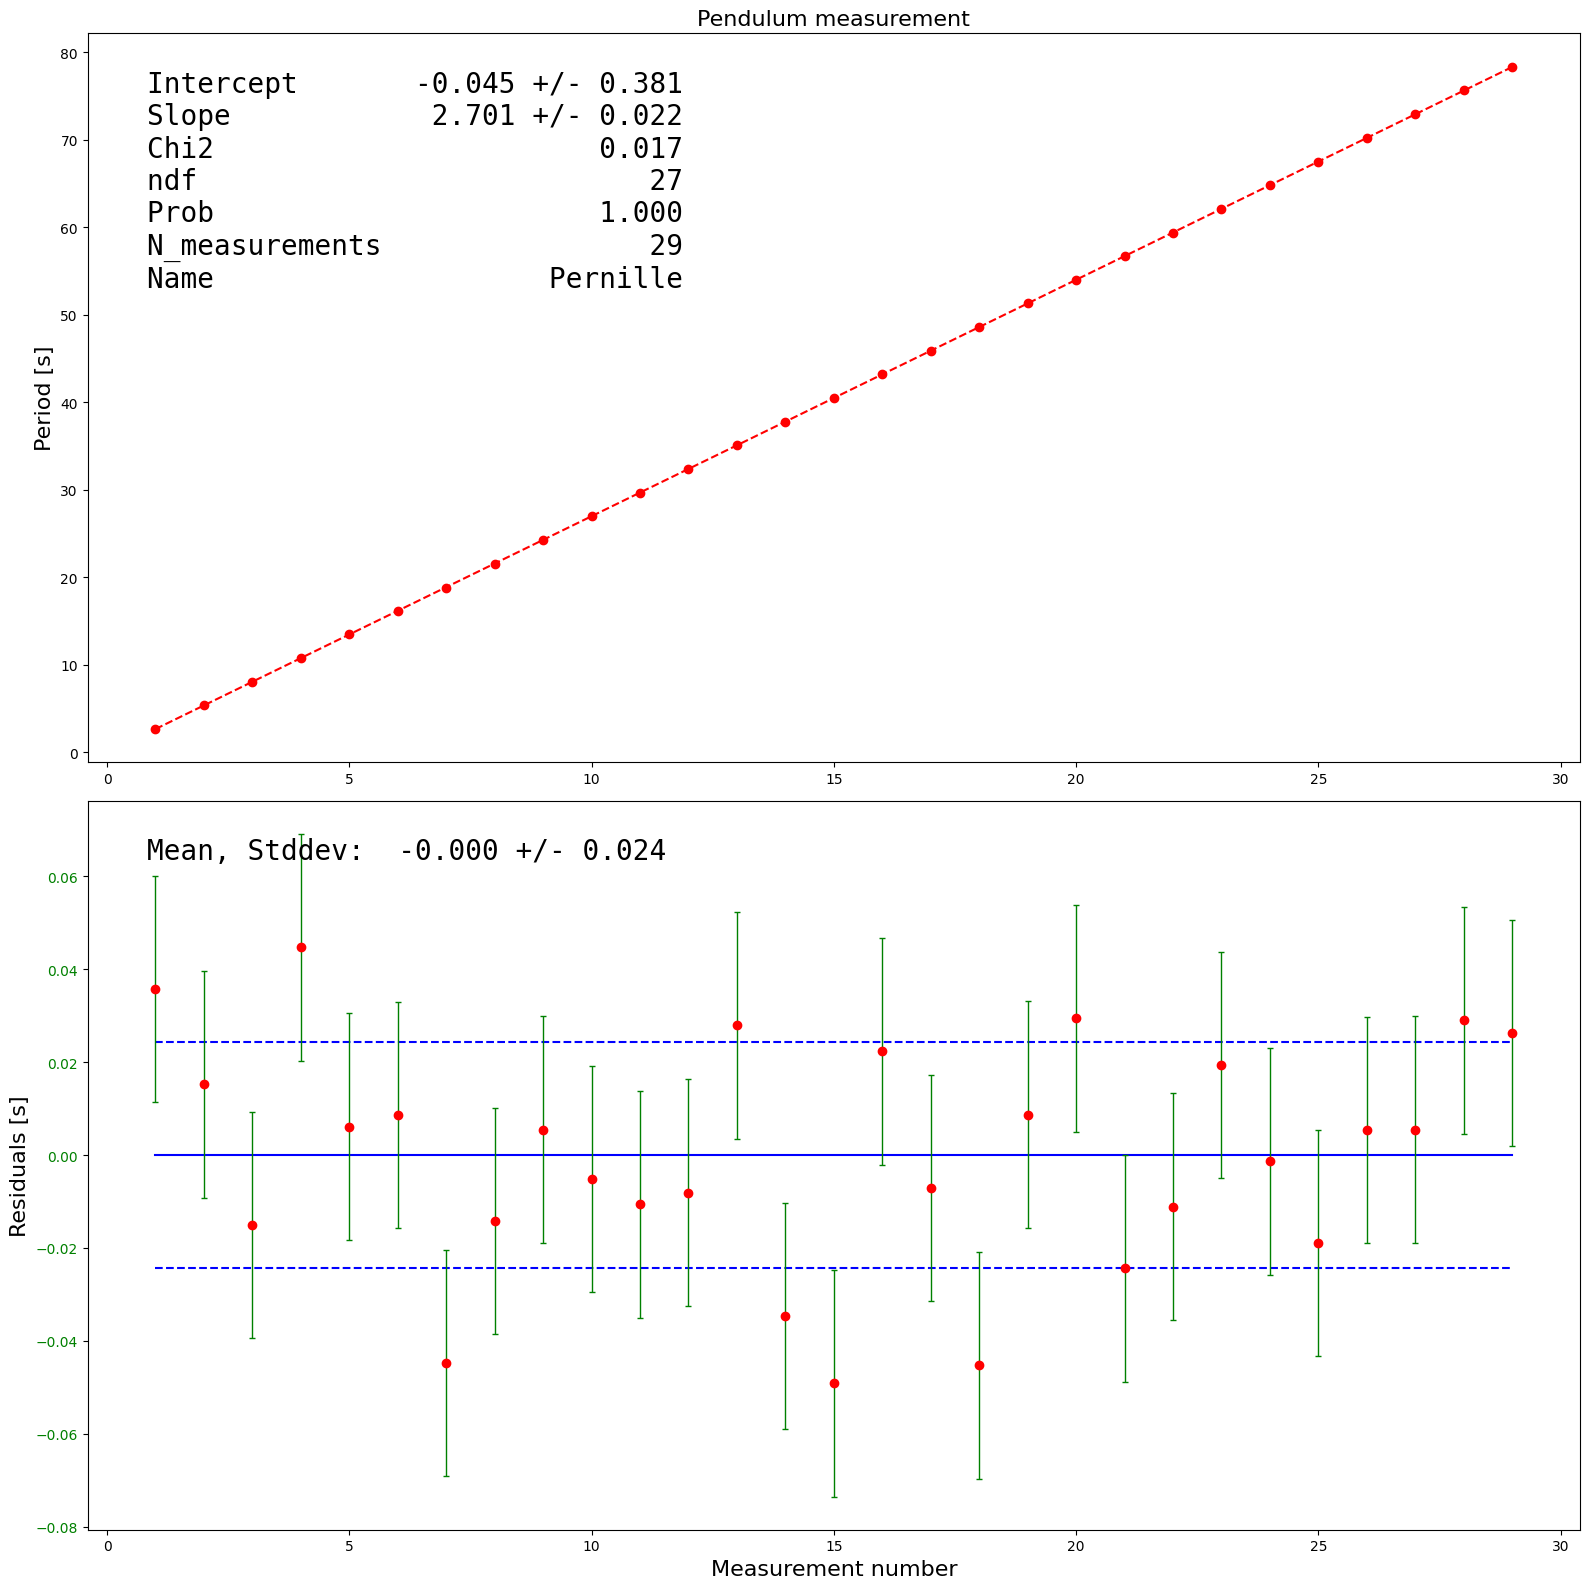

/Users/oscarobel/Github/AppStat2023-Project/External_Functions/ExternalFunctions.py:113: VisibleDeprecationWarning: make_func_code is deprecated: Use of ``func_code`` attribute to declare parameters is deprecated. Use ``_parameters`` instead, which is a dict of parameter names to limits.
  self.func_code = make_func_code(describe(self.f)[1:])


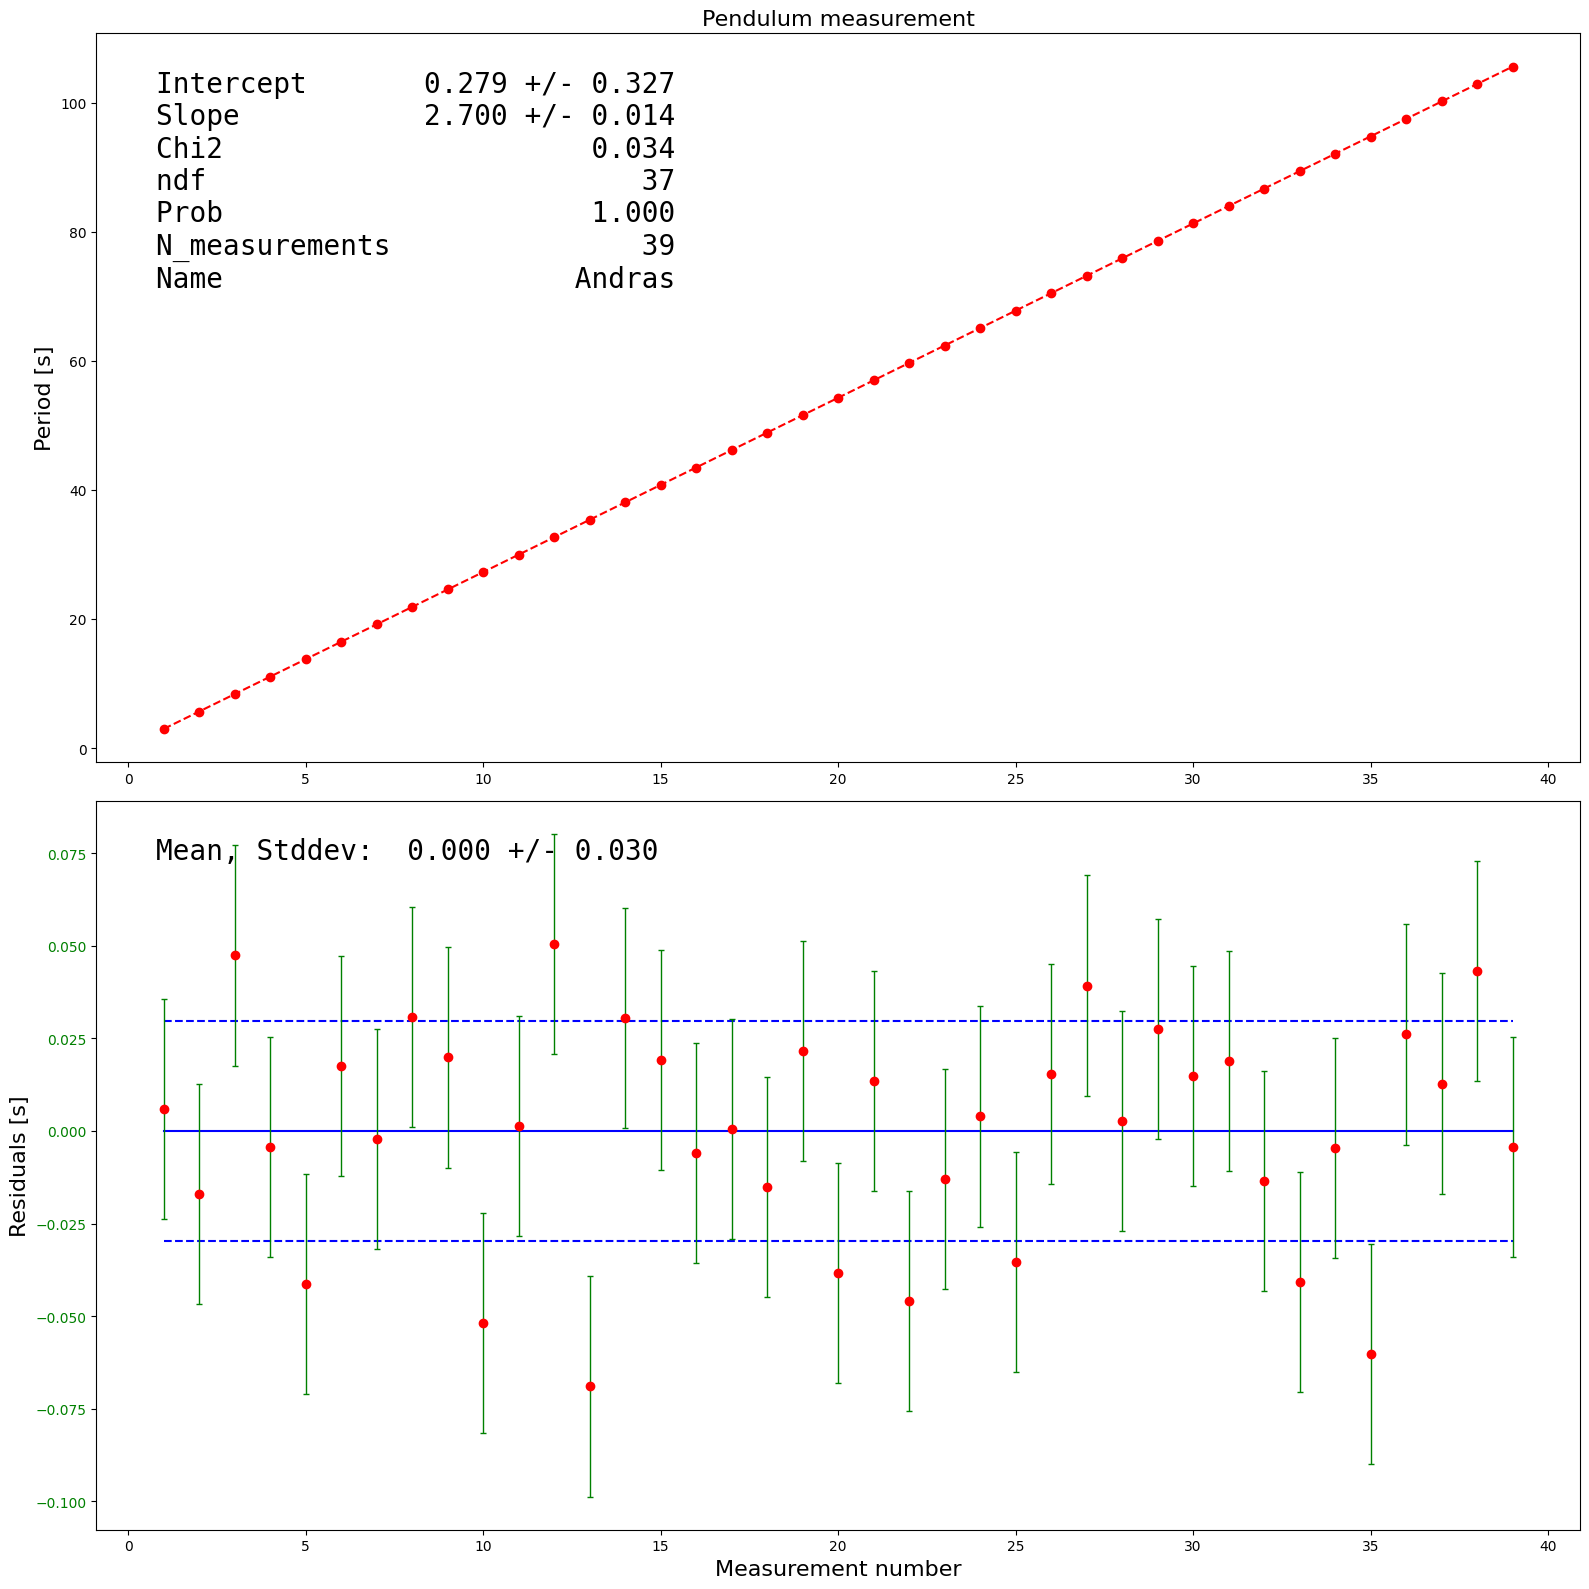

/Users/oscarobel/Github/AppStat2023-Project/External_Functions/ExternalFunctions.py:113: VisibleDeprecationWarning: make_func_code is deprecated: Use of ``func_code`` attribute to declare parameters is deprecated. Use ``_parameters`` instead, which is a dict of parameter names to limits.
  self.func_code = make_func_code(describe(self.f)[1:])


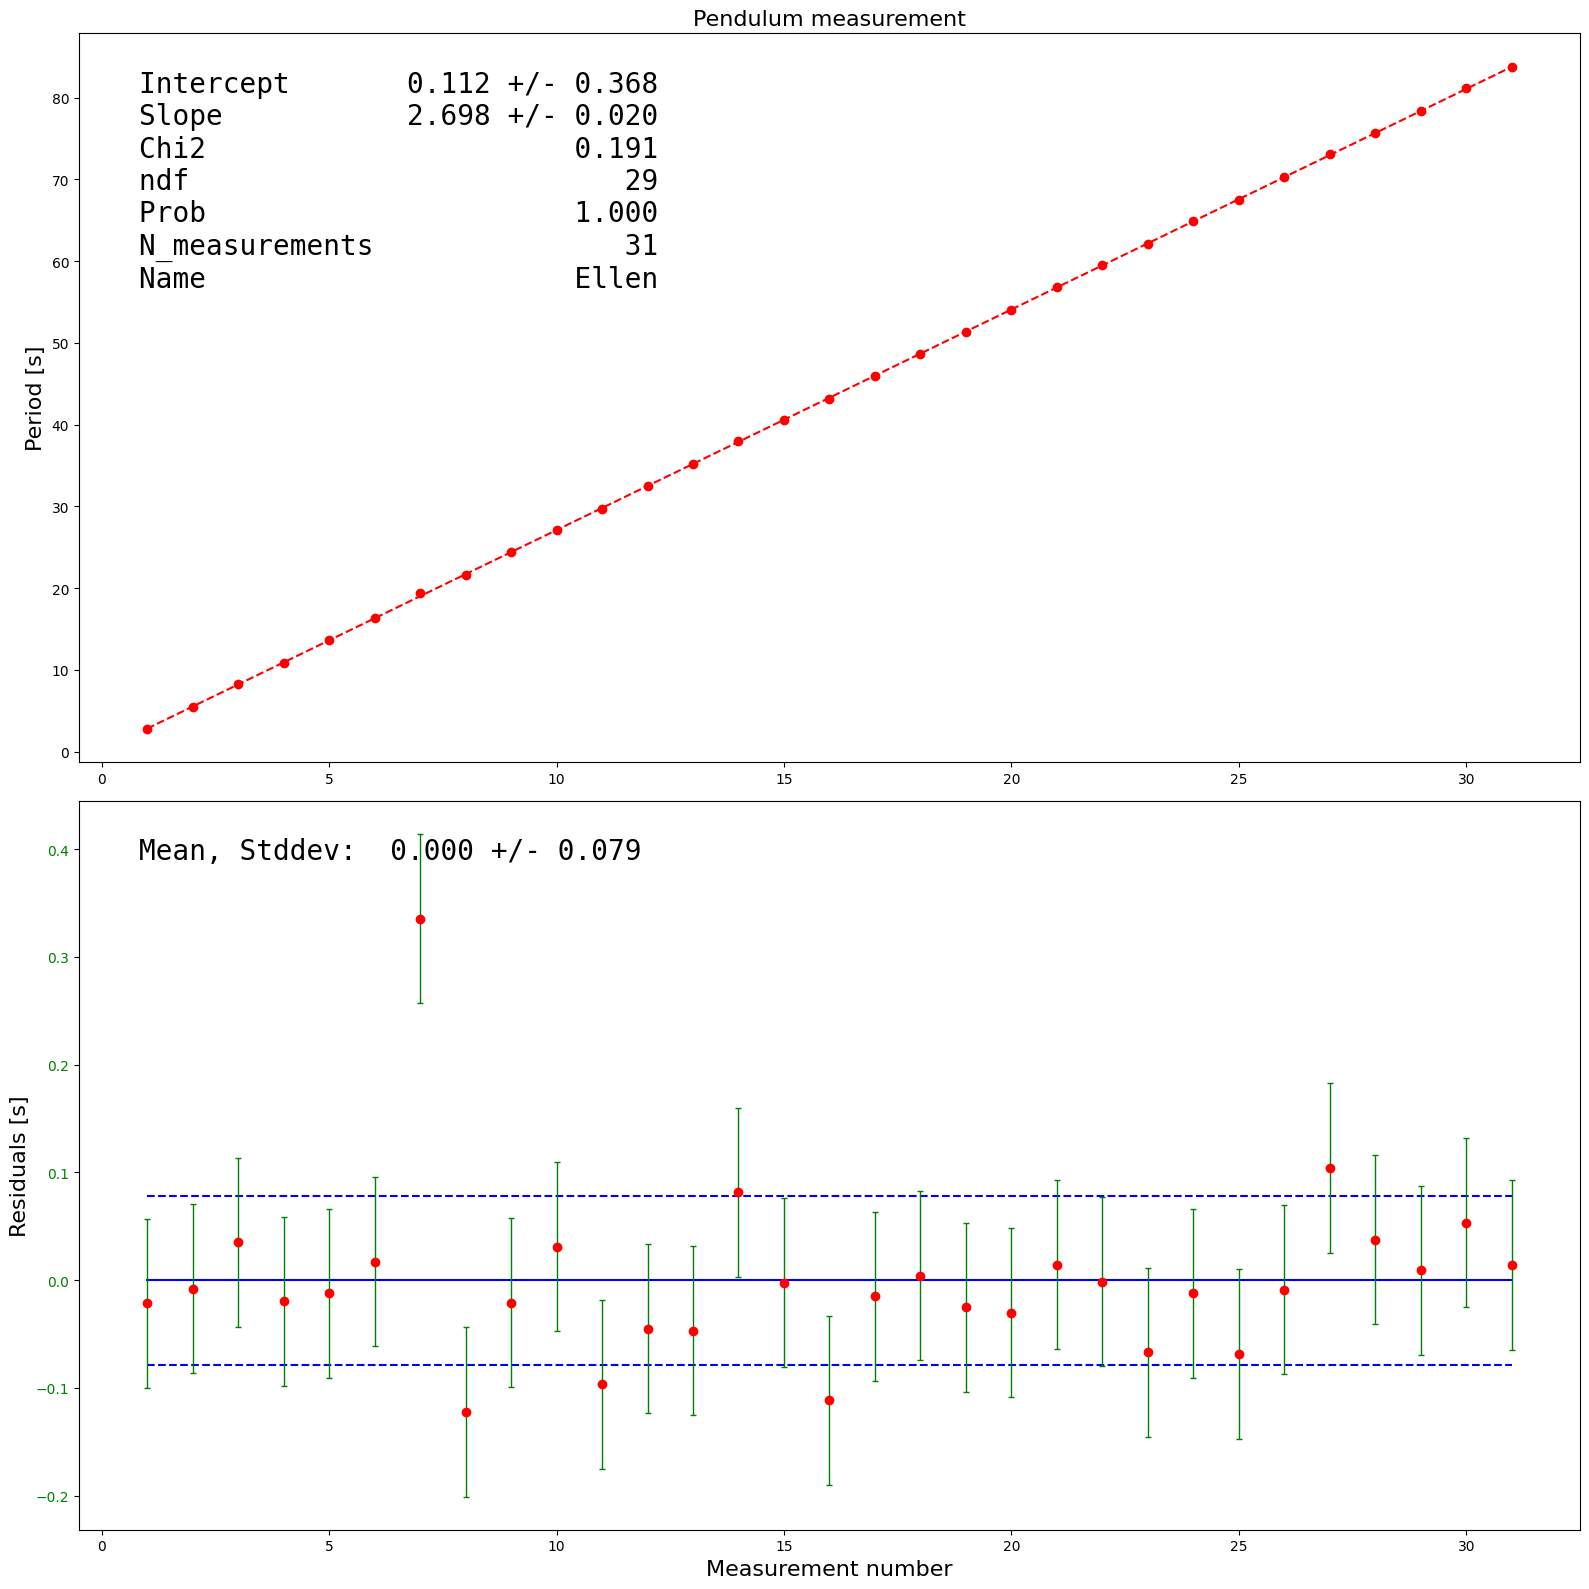

/Users/oscarobel/Github/AppStat2023-Project/External_Functions/ExternalFunctions.py:113: VisibleDeprecationWarning: make_func_code is deprecated: Use of ``func_code`` attribute to declare parameters is deprecated. Use ``_parameters`` instead, which is a dict of parameter names to limits.
  self.func_code = make_func_code(describe(self.f)[1:])


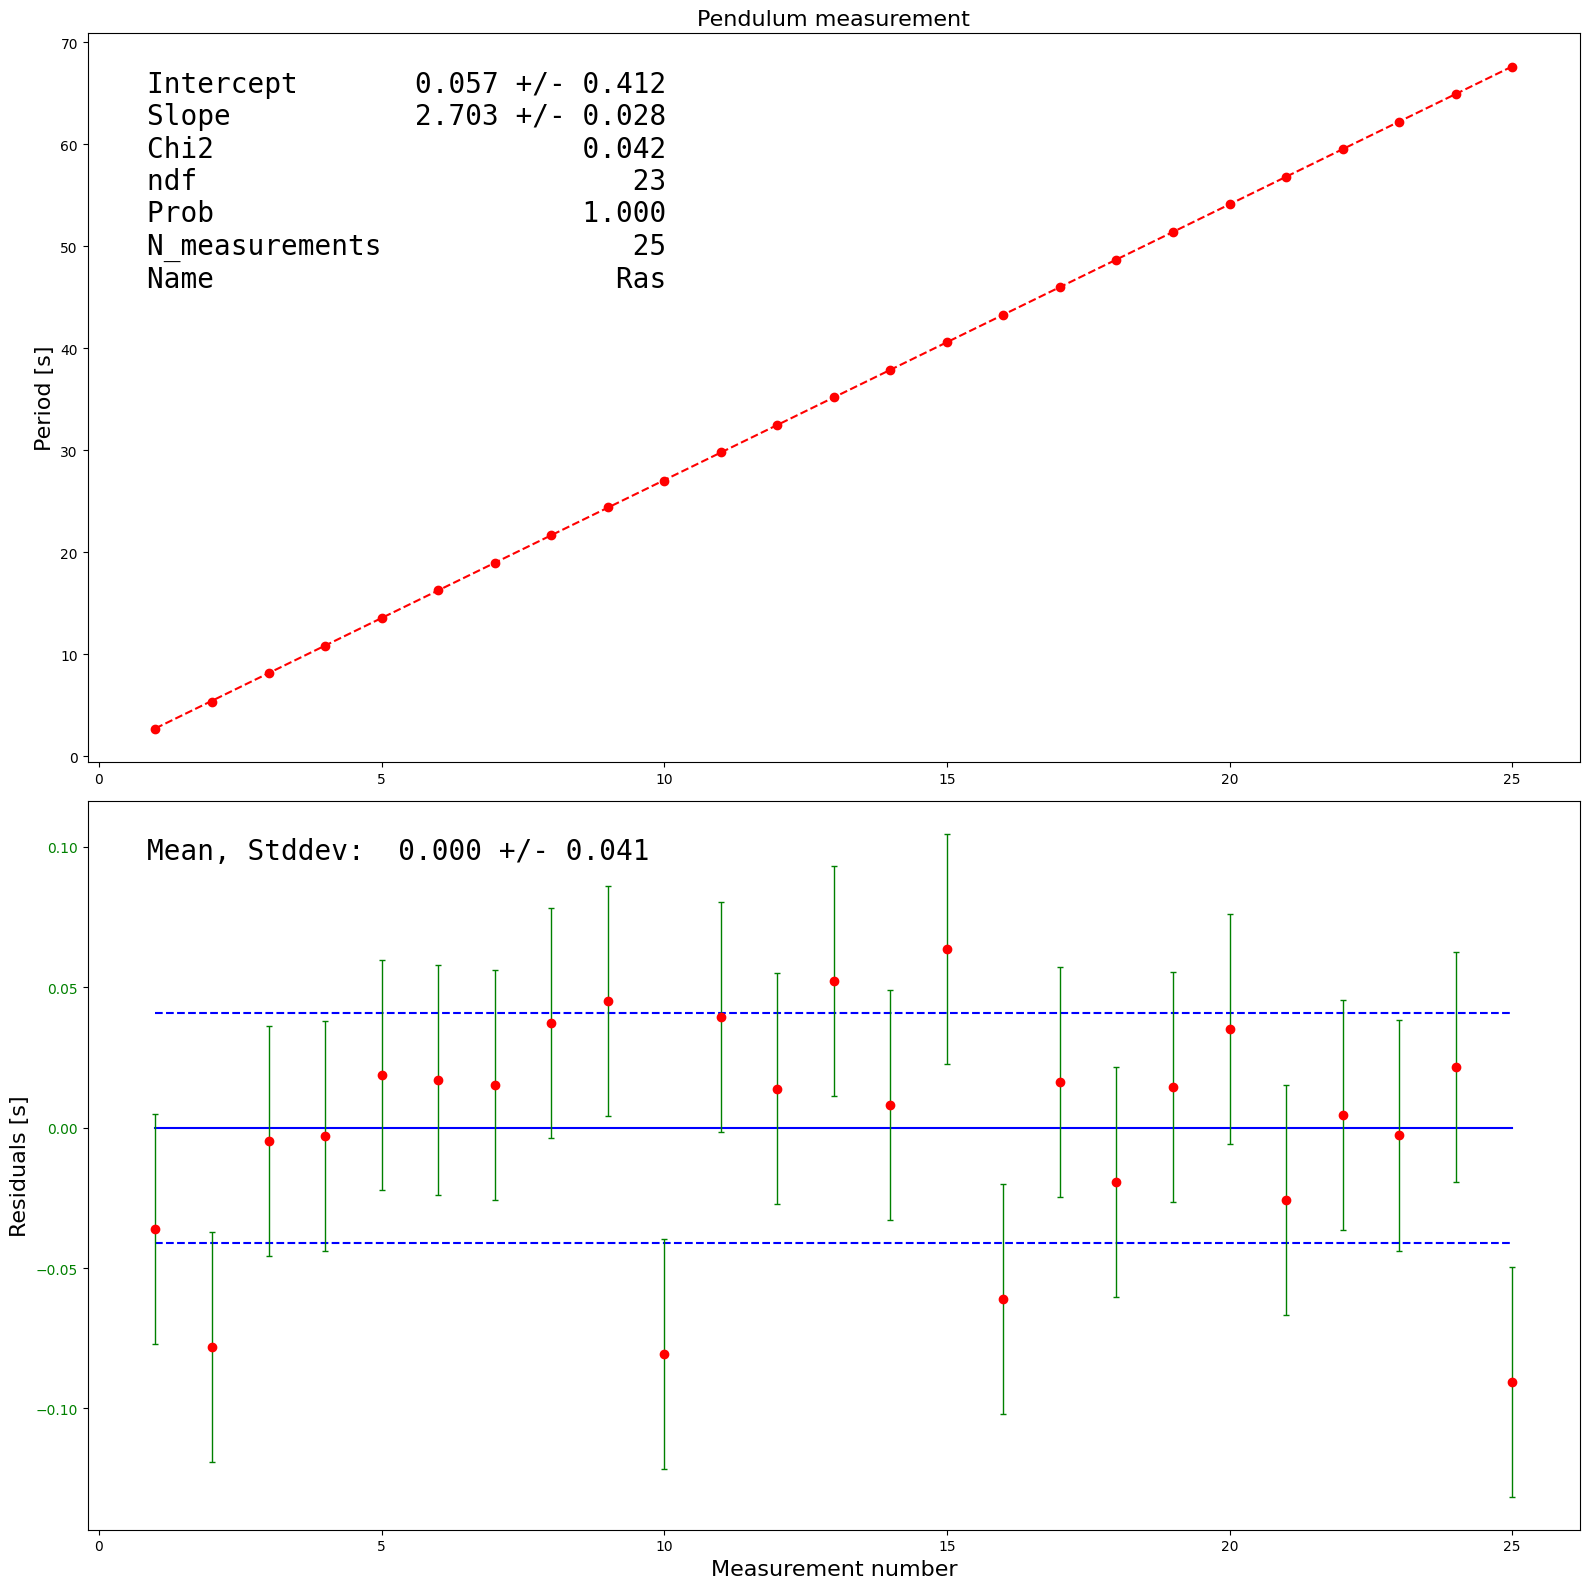

In [309]:
# plot the data and fit

for iexp in range(N_exp):
    N_measurements = len(periods[iexp])
    x_data = np.arange(N_measurements)+1
    
    chi2_object = Chi2Regression(linear_model, x_data, periods[iexp])
    m = Minuit(chi2_object,a=7.5,b=0)
    m.migrad()

    Chi2Lin = m.fval # the chi2 value
    NvarLin = 2                      # Number of variables (alpha0 and alpha1)
    NdofLin = N_measurements - NvarLin   # Number of degrees of freedom
    ProbLin =  stats.chi2.sf(Chi2Lin, NdofLin) # The chi2 probability given N_DOF degrees of freedom
    



    residual = periods[iexp] - linear_model(x_data, m.values['a'], m.values['b'])
    residuals.append(residual)

    residual_rmse = calculate_rms_residuals(x_data, periods[iexp], m.values[:])
    residuals_rmse.append(residual_rmse)

    
    
    mean, stddev = stats.norm.fit(residual)
    #print(mean, stddev)

    
    fig, axes = plt.subplots(nrows=2, figsize=(16, 16))
    ax=axes[0]
    ax.errorbar(x_data, periods[iexp],0.033, fmt='ro', ecolor='b', elinewidth=1, capsize=2, capthick=1)
    ax_res = axes[1]
    #share x only
    ax_res.set_xlim(ax.get_xlim())

    
    ax.plot(x_data, linear_model(x_data, *m.values[:]), '--r')
    
    ax_res.set_xlabel('Measurement number', fontsize=16)
    ax.set_ylabel('Period [s]', fontsize=16)
    ax.set_title('Pendulum measurement', fontsize=16)


    ax_res.plot(x_data, np.zeros_like(x_data), '-b')
    ax_res.plot(x_data, np.full_like(x_data,stddev,dtype=float), '--b')
    ax_res.plot(x_data, np.full_like(x_data,-stddev,dtype=float), '--b')
    ax_res.errorbar(x_data, residual,stddev, fmt='ro', ecolor='g', elinewidth=1, capsize=2, capthick=1)
    # set ax_res to only fill the botoom quarter of the figure 
    ax_res.set_ylabel('Residuals [s]', fontsize=16)
    ax_res.tick_params(axis='y', labelcolor='g')
    
    # mean, stddev = stats.norm.fit(residual_rmse)
    # ax_rms.plot(x_data, np.zeros_like(x_data), '-b')
    # ax_rms.plot(x_data, np.full_like(x_data,stddev,dtype=float), '--b')
    # ax_rms.plot(x_data, np.full_like(x_data,-stddev,dtype=float), '--b')
    # ax_rms.errorbar(x_data, residual,stddev, fmt='ro', ecolor='g', elinewidth=1, capsize=2, capthick=1)
    # ax_rms.set_ylabel('Residuals [s]', fontsize=16)
    # ax_rms.tick_params(axis='y', labelcolor='g')
    # ax_rms.set_xlabel('Measurement number', fontsize=16)
    # ax_rms.set_ylabel('Residuals [s]', fontsize=16)

    d_rms = {'Mean, Stddev:': [mean, stddev]}    

    # add_text_to_ax(0.04, 0.95, nice_string_output(d_rms, extra_spacing=2, decimals=3), ax_rms, fontsize=20)

    mean, stddev = stats.norm.fit(residual)

    d_res = {'Mean, Stddev:': [mean, stddev]}    

    add_text_to_ax(0.04, 0.95, nice_string_output(d_res, extra_spacing=2, decimals=3), ax_res, fontsize=20)

    d = {'Intercept':[m.values['b'], m.errors['b']],
        'Slope':    [m.values['a'], m.errors['a']],
        'Chi2':     Chi2Lin,
        'ndf':      NdofLin,
        'Prob':     ProbLin,
        'N_measurements': N_measurements,
        'Name': Names[iexp]
        }
    
    Pendulum_Slope[iexp] = m.values['a']
    Pendulum_stddev[iexp] = stddev
    Pendulum_error[iexp] = m.errors['a']
    text = nice_string_output(d, extra_spacing=2, decimals=3)
    add_text_to_ax(0.04, 0.95, text, ax, fontsize=20)
    
    if Plot_everything:
        fig.tight_layout()
        plt.show()
        fig.savefig(f'Plots/Pendulum_{Names[iexp]}.pdf', dpi=800)






/Users/oscarobel/Github/AppStat2023-Project/External_Functions/ExternalFunctions.py:113: VisibleDeprecationWarning: make_func_code is deprecated: Use of ``func_code`` attribute to declare parameters is deprecated. Use ``_parameters`` instead, which is a dict of parameter names to limits.
  self.func_code = make_func_code(describe(self.f)[1:])
/Users/oscarobel/Github/AppStat2023-Project/External_Functions/ExternalFunctions.py:121: RuntimeWarning: divide by zero encountered in divide
  chi2 = np.sum(self.weights*(self.y - f)**2/self.sy**2)


inf 27 0.0


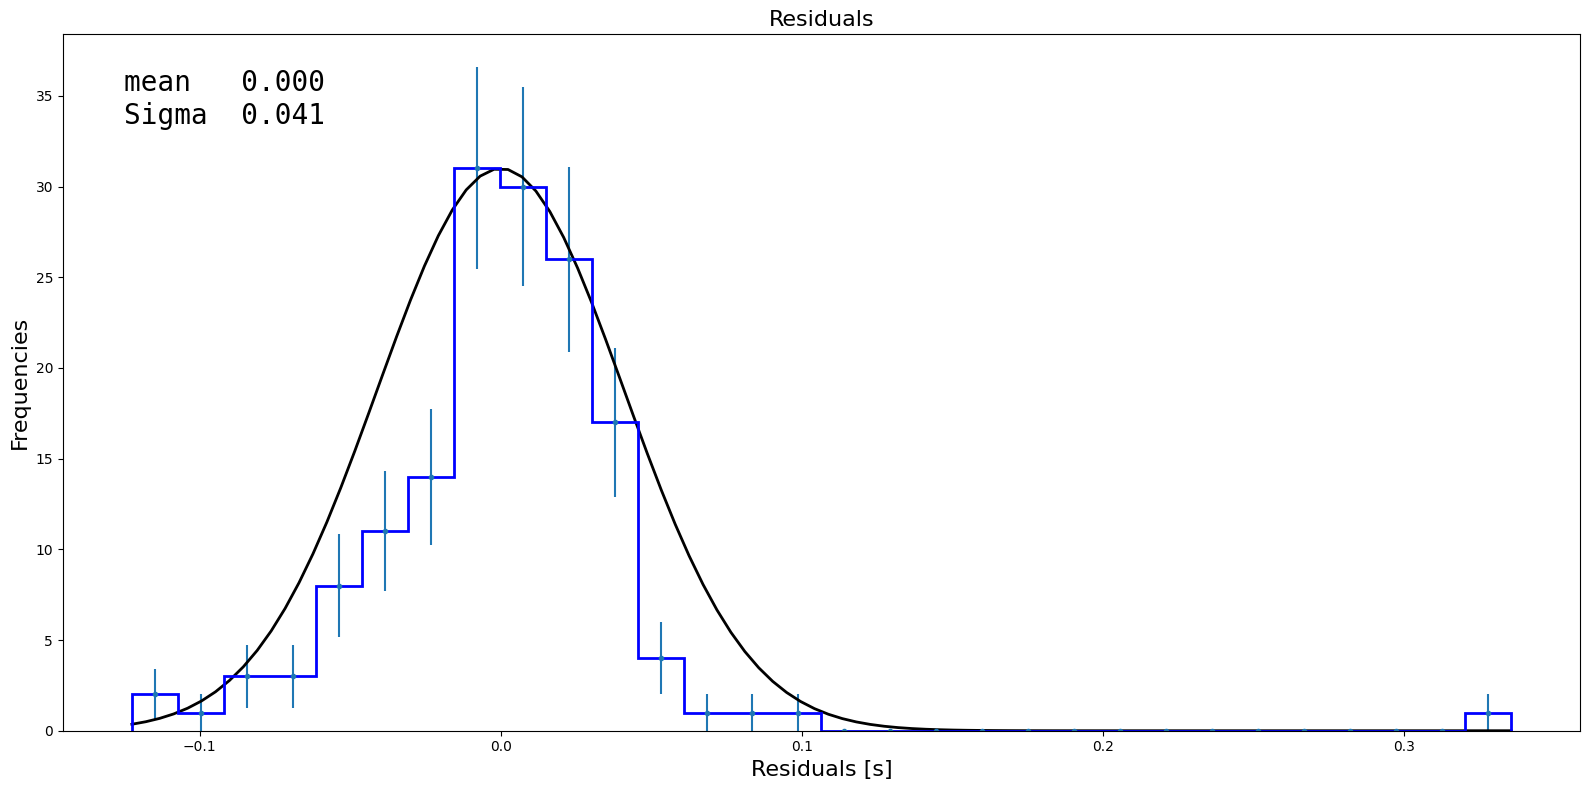

In [313]:
residual_bins = np.hstack(residuals)
residual_bins.sort()
N_bins = 30
y, bin_edges = np.histogram(residual_bins, bins=N_bins)
x = 0.5*(bin_edges[:-1] + bin_edges[1:])
sy = np.sqrt(y) 

# Fit the histogram with a Gaussian using iminuit
chi2_object = Chi2Regression(gaussian, x, y, sy)
m = Minuit(chi2_object, amplitude=max(y), mean=mean, stddev=stddev)
m.migrad()

Chi2Gauss = m.fval # the chi2 value
NvarGauss = 3                      # Number of variables (alpha0 and alpha1)
NdofGauss = N_bins - NvarGauss   # Number of degrees of freedom
ProbGauss =  stats.chi2.sf(Chi2Gauss, NdofGauss) # The chi2 probability given N_DOF degrees of freedom
mean = m.values['mean']
stddev = m.values['stddev']

print(Chi2Gauss, NdofGauss, ProbGauss)

x_gauss = np.linspace(min(residual_bins), max(residual_bins), 100)

# Plot the histogram
fig, ax = plt.subplots(figsize=(16, 8))
hist = ax.errorbar(x, y, sy, fmt='.')
ax.plot(x_gauss, gaussian(x_gauss, max(y), mean, stddev), 'k', linewidth=2)

ax.hist(residual_bins, bins=N_bins, histtype='step', color='b', linewidth=2)


ax.set_xlabel('Residuals [s]', fontsize=16)
ax.set_ylabel('Frequencies', fontsize=16)
ax.set_title('Residuals', fontsize=16)



dd = {'mean':mean,
    'Sigma':stddev,

    }
text2 = nice_string_output(dd, extra_spacing=2, decimals=3)
add_text_to_ax(0.04, 0.95, text2, ax, fontsize=20)

fig.tight_layout()
fig.savefig(f'Plots/Pendulum_residuals.pdf', dpi=800)




In [314]:
# Remove the outliers




[0.02109357 0.02219484 0.01422776 0.02008048 0.02773501]
Weighted mean: 2.701 +/- 0.014
Weighted2 mean: 2.700 +/- 0.009


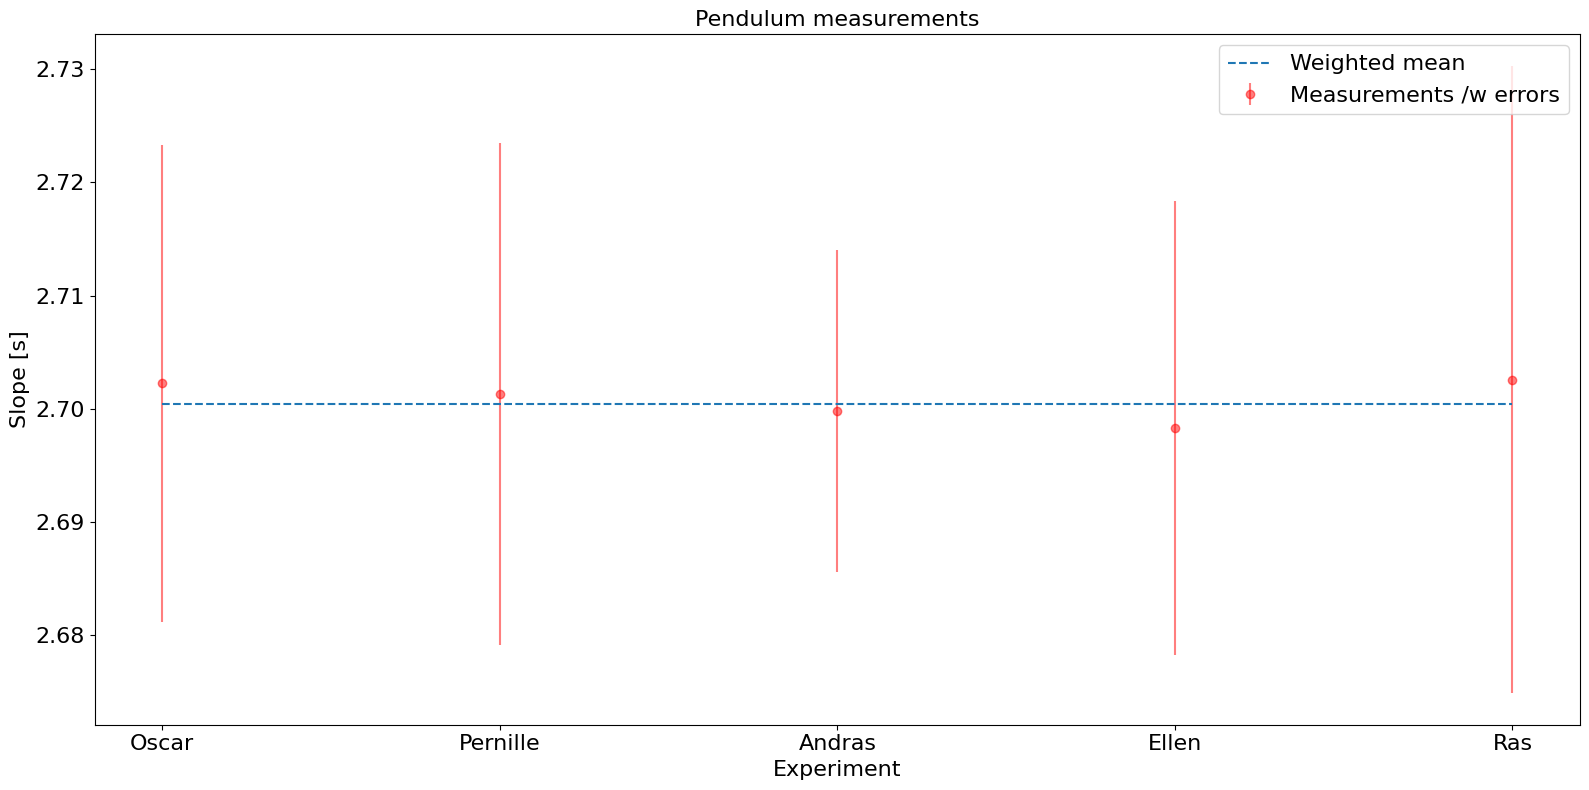

In [317]:
# Calculate weighted mean and std
periods = Pendulum_Slope
error = Pendulum_stddev
error2 = Pendulum_error
weights = 1/error**2
weights2 = 1/error2**2
weighted_mean = np.sum(weights*periods)/np.sum(weights)
weighted2_mean = np.sum(weights2*periods)/np.sum(weights2)
weighted_std = np.sqrt(1/np.sum(weights))
weighted2_std = np.sqrt(1/np.sum(weights2))
print(Pendulum_error)
print(f'Weighted mean: {weighted_mean:.3f} +/- {weighted_std:.3f}')
print(f'Weighted2 mean: {weighted2_mean:.3f} +/- {weighted2_std:.3f}')
# Plot the data
fig, ax = plt.subplots(figsize=(16, 8))
# ax.errorbar(np.arange(N_exp), periods, error, fmt='o', label='Measurements', color='b', alpha=0.5)
ax.errorbar(np.arange(N_exp), periods, error2, fmt='o', label='Measurements /w errors', color='r', alpha=0.5)
ax.plot(np.arange(N_exp), np.ones(N_exp)*weighted2_mean, '--', label='Weighted mean')
ax.set_xlabel('Experiment', fontsize=16)
ax.set_ylabel('Slope [s]', fontsize=16)
ax.set_title('Pendulum measurements', fontsize=16)
ax.legend(fontsize=16)
ax.set_xticks(np.arange(N_exp))
ax.set_xticklabels(Names, fontsize=16)
ax.tick_params(axis='y', labelsize=16)



fig.tight_layout()
fig.savefig(f'Plots/Pendulum_weightedmean.pdf', dpi=800)


In [ ]:
# compared for consistency using chi2
chi2_object = Chi2Regression(linear_model, np.arange(N_exp), periods, error)
m = Minuit(chi2_object,a=7.5,b=0)
m.migrad()

Chi2Lin = m.fval # the chi2 value
NvarLin = 2                      # Number of variables (alpha0 and alpha1)
NdofLin = N_exp - NvarLin   # Number of degrees of freedom
ProbLin =  stats.chi2.sf(Chi2Lin, NdofLin) # The chi2 probability given N_DOF degrees of freedom

print(f'Chi2: {Chi2Lin:.3f}, Ndof: {NdofLin}, Prob: {ProbLin:.3f}')

# compared for consistency using chi2 with weighted mean and gaussian error



Chi2: 0.006, Ndof: 3, Prob: 1.000


/Users/oscarobel/Github/AppStat2023-Project/External_Functions/ExternalFunctions.py:113: VisibleDeprecationWarning: make_func_code is deprecated: Use of ``func_code`` attribute to declare parameters is deprecated. Use ``_parameters`` instead, which is a dict of parameter names to limits.
  self.func_code = make_func_code(describe(self.f)[1:])


In [ ]:
# Load measured lengths and angles 
data = pd.read_pickle('Data/values_P.pkl')
data

,l_PendulumToHook_START,w_Pendulum,l_COM_START,l_PendulumToFloor_START,l_PendulumToFloor_END,l_PendulumToFloor_CHANGE,l_PendulumToHook_END,l_COM_END
0,180.00,2.50,181.250000,23.8,23.60,0.200000,180.200000,181.45000
1,0.01,0.02,0.017321,0.1,0.01,0.100499,0.100995,0.10198


In [ ]:
# Import SymPy: 
from sympy import * 
    
# Define variables:
L,T, gp = symbols("L, T, g_pendulum")
dL,dT,dgp = symbols("sigma_L, sigma_T,sigma_gP")

# Pendulum:
# Define relation, and print:
gp = L * (2 * pi / T)**2 
lprint(latex(Eq(symbols('g_pendulum'),gp)))

# Calculate uncertainty and print:
dgp = sqrt((gp.diff(L) * dL)**2 + (gp.diff(T) * dT)**2)
lprint(latex(Eq(symbols('sigma_gP'), dgp)))

# Turn expression into numerical functions 
fP = lambdify((L,T),gp)
fdP = lambdify((L,dL,T,dT),dgp)

# Define values and their errors
# vL, vdL = mu1,sig1
# vT, vdT = mu2,sig2

vL, vdL = 1.8125,0.0001
vT, vdT = Pendulum_Slope.mean(),stddev
print(vT)
print(vdT)

# Numerically evaluate expressions and print 
vP = fP(vL,vT)
vdP = fdP(vL,vdL,vT,vdT)
lprint(fr'g = ({vP:.3f} \pm {vdP:.3f})\,\mathrm{{m/s^2}}')




# NOTE: Do the above analytical calculation before you continue below! Possibly use SymPy for the differentiations.

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

2.7008275447192736
0.04471288173324876


<IPython.core.display.Latex object>

### Ball on incline
 
- Rolling ball timing and gate positions: Remember, doing (too) many experiments won't decrease the error (why?)!
- Rolling ball acceleration: I.e. combining the above with gate times in quadratic fit.
- Rolling ball diameter and rail distance: Done with a caliper (DK: skydelaerer).
- Rolling ball incline angle: With goniometer (DK: vinkelmaaler) and from trigonometry.
- Rolling ball table angle: Measured by turning the experiment 180 degrees and cross checked by goniometer. Was it consistent with being level?
And finally, you should of course combine your measurements to one value of g for each setup and compare the value and precision with a reference.